# TensorFlow Example

The first problem we look at should be familiar, since it was in the notes for Module 3. Let's generate training data.

## Import the necessary modules

In [1]:
import IPython.display
import numpy as np
from numpy.random import randint
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from skimage import io
from ipywidgets import interact

from IPython.display import HTML
from IPython.display import display
from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.facecolor'] = "0.92"

### Training data
First, we generate training data, making sure that we have a good overlap of classes. To do this, we use two randomly generated Gaussian-distributed clouds of points in 2D-space.

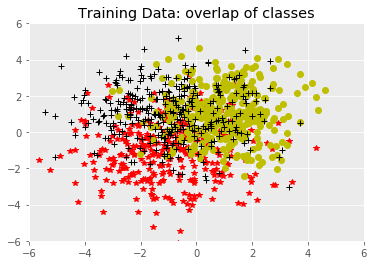

In [2]:
np.random.seed(0)

# Number of points
N = 1000
# Labels for each cluster
y = np.random.randint(low=0, high=3, size = N)
# Mean of each cluster
means = np.array([[-1, 1, -1], [-1, 1, 1],])
# Covariance (in X and Y direction) of each cluster
covariances = np.random.random_sample((2, 3)) + 1
# Dimensions of each point
X = np.vstack([np.random.randn(N)*covariances[0, y] + means[0, y],
               np.random.randn(N)*covariances[1, y] + means[1, y]])
X = X.T
# Convert to targets, as floatX
t = np.zeros((N,3))
for i in range (N):
    t[i,y[i]]=1

label = np.argmax(t,axis=1)

# Plot the data
col = ['r*','yo','k+', 'g*', 'b*']

for cl in range(3):
    cl_labels = np.array([label==cl]).flatten()
    X_cl = X[cl_labels,:]
    plt.plot(X_cl[:,0],X_cl[:,1],col[cl])
    
plt.axis([-6, 6, -6, 6])
plt.title('Training Data: overlap of classes')
plt.show()

## Create the model in TensorFlow

We want to do the classification using TensorFlow. You will recall that this proceeds in two steps. First is the construction step:

### Construction step

In [3]:
tf.reset_default_graph()

# Set placeholders
x = tf.placeholder(tf.float32, [None, 2])  #2D features
y_ = tf.placeholder(tf.float32, [None, 3]) #3 classes

# Set Variables
W = tf.Variable(tf.truncated_normal([2,3], stddev=0.1))
b = tf.Variable(tf.truncated_normal([3], stddev=0.1))

# Set Constants
lr = tf.constant(0.1)

# Softmax
y = tf.nn.softmax(tf.matmul(x, W) + b)

## Cross entropy

We use the cross entropy as objective function.

In [4]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

### Calculate the gradients and updates
We use Tensorflow to calculate the gradients. 

In [5]:
grad_W = tf.gradients(cross_entropy,W)
grad_b = tf.gradients(cross_entropy,b)

W_update = tf.assign(W,W-lr*grad_W[0])  
b_update = tf.assign(b,b-lr*grad_b[0])

init_op = tf.global_variables_initializer()  # Initialiser op


## Run the session

* Up to this point, everything is symbolic.
* At runtime, the placeholders are populated by values and the nodes a executed.

### Execution Step

We are now ready to execute

In [6]:
with tf.Session() as sess:
  # Run the 'init' op. 
  sess.run(init_op)
    
  for i in range(100): 
     sess.run(W_update, feed_dict={y_:t,x:X})
     sess.run(b_update, feed_dict={y_:t,x:X})
      
  predict = sess.run(y, feed_dict={x:X})
  weights = W.eval()
  offsets = b.eval()

print('Weights shape:', weights.shape)
print('Offsets shape:', offsets.shape)
print('Predictions shape:', predict.shape)

Weights shape: (2, 3)
Offsets shape: (3,)
Predictions shape: (1000, 3)


## Visualise the results

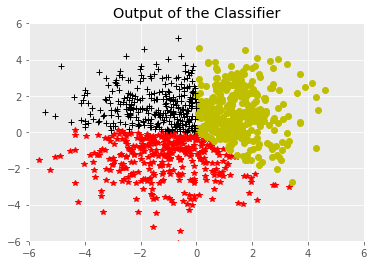

In [7]:
label = np.argmax(predict,axis=1)

# Plot the data
col = ['r*','yo','k+', 'g*', 'b*']

for cl in range(3):
    cl_labels = np.array([label==cl]).flatten()
    X_cl = X[cl_labels,:]
    plt.plot(X_cl[:, 0], X_cl[:, 1], col[cl])
    
plt.axis([-6, 6, -6, 6])
plt.title('Output of the Classifier')
plt.show()

**Linear separation**

This is clearly a linear separation of the classes. Since we use a linear separation, we cannot expect to do any better than this. In fact, this is a rather hard problem because of the considerable overlap between the classes. Let’s now introduce nonlinearity. For that, we generate a new dataset that will illustrate the power of nonlinearity.

---
## A nonlinear example
Next, let's generate data in that of a spiral formation.

In [8]:
# Functions
def generate_spiral_data(num_classes, dimensions, points_per_class):
    """
    Generate `num_classes` spirals with `points_per_class` points per spiral.
    """
    
    # Create an empty matrix to hold our X values
    X = np.zeros((points_per_class * num_classes, dimensions), dtype='float32')
    # Create an empty vector to hold our y values
    y = np.zeros(points_per_class * num_classes, dtype='uint8')    

    # Generate data for each class
    for y_value in range(num_classes):     
        # The indices in X and y where we will save this class of data
        ix = range(points_per_class * y_value, points_per_class * (y_value + 1))
        
        # Generate evenly spaced numbers in the interval 0 to 1
        radius = np.linspace(0.0, 1, points_per_class)    
        theta = np.linspace(y_value * 4, (y_value + 1) * 4, points_per_class) + np.random.randn(points_per_class) * 0.2    

        # Convert polar coordinates to standard Euclidian coordinates
        X[ix] = np.column_stack([radius * np.sin(theta), radius * np.cos(theta)])
        y[ix] = y_value
    
    return X, y
    
    
def plot_data(X, y):
    """
    Use Matplotlib to plot X, y data on a figure.
    """
    
    fig = plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    return fig

In [9]:
np.random.seed(0)  # Setting a random seed allows us to get the exact same data each time we run the cell.
num_classes = 3  # The number of classes (distinct groups) of data (these are our "y" values)
dimensions = 2  # The number of dimensions of our input or "X" values
points_per_class = 300  # number of X points to generate for each of the y values

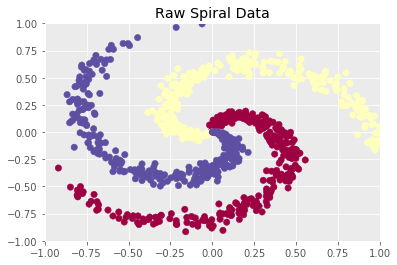

In [10]:
# Generate and plot data
X, Y_ = generate_spiral_data(num_classes, dimensions, points_per_class)
fig = plot_data(X, Y_)
plt.title('Raw Spiral Data')
plt.show()

# Convert labels to one-hot encoding
t = np.zeros((Y_.shape[0], 3), dtype=int)
for i in range(Y_.shape[0]):
    t[i, Y_[i]] = 1

You can see that the spiral has 3 different classes: red, blue, and yellow.

#### Let's first fit a model that performs linear classification

In [11]:
# Construction
# ============
tf.reset_default_graph()

# Set placeholders
x = tf.placeholder(tf.float32, [None, 2])  #2D features
y_ = tf.placeholder(tf.float32, [None, 3]) #3 classes

# Set Variables
W = tf.Variable(tf.truncated_normal([2,3], stddev=0.1))
b = tf.Variable(tf.truncated_normal([3], stddev=0.1))

# Set Constants
lr = tf.constant(0.1)

# Softmax
y = tf.nn.softmax(tf.matmul(x, W) + b)

# Cost Function
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

# Set gradients and update rule
grad_W = tf.gradients(cross_entropy,W)
grad_b = tf.gradients(cross_entropy,b)
W_update = tf.assign(W, W - lr * grad_W[0])  
b_update = tf.assign(b, b - lr * grad_b[0])

# Initialiser op
init_op = tf.global_variables_initializer() 

# Execution
# =========
with tf.Session() as sess:
  # Run the 'init' op. 
  sess.run(init_op)
    
  for i in range(100): 
     sess.run(W_update, feed_dict={y_:t, x:X})
     sess.run(b_update, feed_dict={y_:t, x:X})
      
  predict = sess.run(y, feed_dict={x:X})
  weights = W.eval()
  offsets = b.eval()

print('Weights shape:', weights.shape)
print('Offsets shape:', offsets.shape)
print('Predictions shape:', predict.shape)

Weights shape: (2, 3)
Offsets shape: (3,)
Predictions shape: (900, 3)


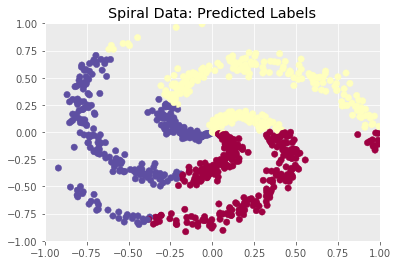

In [12]:
# Visualise the results of the linear model
label = np.argmax(predict, axis=1)
fig = plot_data(X, label)
plt.title('Spiral Data: Predicted Labels')
plt.show()

**Conclusion:**
This is not a good fit. We can see the SoftMax classification fails to correctly identify the data points. It is unable to learn the nonlinear pattern of the data.

---
## Adding a Hidden Layer

In order to do better, we need to introduce another nonlinear layer to our neural network. 

Assuming $D$-dimensional input $x$, the first, hidden, layer is given by
\begin{align}
\mathbf{h}_1 &= \mbox{relu}(\mathbf{z}_1)\\
\end{align}
where
\begin{align}
\mathbf{z}_1 &= W_1^T \mathbf{x} + \mathbf{b}_1 \mbox{  and   }\mbox{ relu}(x) = \max(0,x).
\end{align}
**Note:** The number of neurons in the hidden layer is a hyperparameter that must be specified by the user. That is, if the input dimension is $D$ as before, $W_1$ is an $D \times H_1$ dimensional tensor, where $H_1$ has to be specified by you, the user. 

The $\mathbf{h}_1$ neurons are now simply passed on to the softmax layer, and therefore behaves exactly as our linear model above. From the output of the softmax function, we can again calculate the cross entropy, and all that remains is to calculate the gradient. The algebra becomes tedious, but the ideas are exactly the same as for the linear problem.  

**Backward pass: Deriving the gradients** 

Our model has now changed a little, but notice that $W_2$ (which maps from the hidden layer to logits) is now doing the same thing as $W$ in our linear model, just on a transformed version of the inputs $\mathbf{h}_1$.

So the good news is that the *mechanics* of computing the gradient wrt $W_2$ will be similar to how we derived $\frac{\partial E}{\partial W}$ for the linear model above, but now we just need to replace 'input activations' $\mathbf{x}$ with the 'hidden activations' $\mathbf{h}_1$ (compare `derivative_loss_W2()` below with `derivative_loss_W()` in the linear model above). 

So, all that's left is to compute $\frac{\partial E}{\partial W_1}$, the gradients on $W_1$ (the input-to-hidden layer weights; omitting the biases for now). For this, we will again use the chain rule to derive 

$\frac{\partial E}{\partial W_1} = \frac{\partial E}{\partial z_2} \frac{\partial z_2}{\partial z_1} \frac{\partial z_1}{\partial W_1}$

Convince yourself that this is again just an application of the [chain rule for derivatives](https://en.wikipedia.org/wiki/Chain_rule), but over a longer chain ($E\rightarrow z_2 \rightarrow z_1 \rightarrow W$)!

**NOTE**:
* The gradient on input weights $W_1$ is a product of three terms.
* We already know the first term $\frac{\partial E}{\partial z_2}$.

**What is happening here?**:

So far, we have been manually deriving the gradients of the loss with respect to all model parameters. Notice that a specific pattern is emerging:
 
* Propagate activations forward through the network ("make a prediction"), 
* Compute an error delta ("see how far we're off") , and 
* Propagate errors backwards to update the weights ("update the weights to do better next time").
 
Derivatives of the loss with respect to the inputs of a layer (e.g. $\frac{\partial E}{\partial z}$) are referred to as (error) **deltas**.    For now we just need the gradients calculated above, but we will use this insight in the next practical when we show how this all forms part of a more general algorithm for efficiently computing gradients in deep neural networks (called **(error) back-propagation**).

---
## Tensorflow implementation

* Add a nonlinear layer with n_hidden_1 = 30 hidden layer neurons.
* Use ReLU as activation function.
* Plot the results of your model.

In [34]:
# Construction
# ============
tf.reset_default_graph()

# Specify the hyperparameters
n_inputs = 2  # Input dimension
n_hidden_1 = 30  # Hidden layer
n_outputs = 3  # Output layer

n_epochs = 3000  # Number of Epochs
n_sample = X.shape[0]  # Input Shape

with tf.name_scope("Inputs"):    
    x = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
    y = tf.placeholder(tf.float32, shape=(None, n_outputs), name="y")

with tf.name_scope("output"):
    fc1    = tf.layers.dense(x, n_hidden_1, activation = tf.nn.relu, name="fc1")
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_prob = tf.nn.softmax(logits, name="Y_prob")

with tf.name_scope("train"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y, name="xentropy")
    loss = tf.reduce_mean(xentropy, name='loss')
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.equal(tf.argmax(logits,axis=1), tf.argmax(y,axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init"):
    init_op = tf.global_variables_initializer()  

In [14]:
# Execution
# =========
with tf.Session() as sess:
    # Run the 'init' op
    sess.run(init_op)
    
    for epoch in range(n_epochs):            
        sess.run(training_op, feed_dict={x: X, y: t})
        
        #Print the training accuracy       
        if epoch % 100==0:
            acc_train = accuracy.eval(feed_dict={x: X, y: t})
            print(epoch, "Train accuracy:", acc_train)   
    
    output_probs = sess.run(Y_prob, feed_dict={x: X, y: t})

0 Train accuracy: 0.3311111
100 Train accuracy: 0.5744445
200 Train accuracy: 0.5877778
300 Train accuracy: 0.6011111
400 Train accuracy: 0.6288889
500 Train accuracy: 0.66888887
600 Train accuracy: 0.70444447
700 Train accuracy: 0.7411111
800 Train accuracy: 0.76666665
900 Train accuracy: 0.8066667
1000 Train accuracy: 0.8322222
1100 Train accuracy: 0.85333335
1200 Train accuracy: 0.87
1300 Train accuracy: 0.8888889
1400 Train accuracy: 0.90444446
1500 Train accuracy: 0.9166667
1600 Train accuracy: 0.92444444
1700 Train accuracy: 0.9311111
1800 Train accuracy: 0.9388889
1900 Train accuracy: 0.95
2000 Train accuracy: 0.9533333
2100 Train accuracy: 0.9622222
2200 Train accuracy: 0.96444446
2300 Train accuracy: 0.97
2400 Train accuracy: 0.9777778
2500 Train accuracy: 0.9777778
2600 Train accuracy: 0.9822222
2700 Train accuracy: 0.98444444
2800 Train accuracy: 0.9855555
2900 Train accuracy: 0.98888886


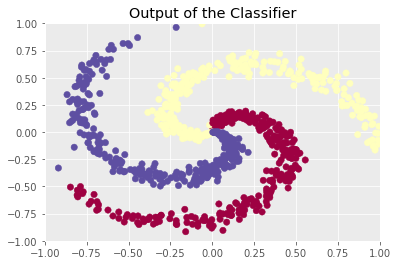

In [15]:
# Visualise the results of the NN with hidden layer
label = np.argmax(output_probs,axis=1)
fig = plot_data(X, label)
plt.title('Output of the Classifier')
plt.show()

### Conclusion: 

You can see from the plot above that, by adding a hidden layer, introducing nonlinearities, the model performance is dramatically improved.

___
### Keras implementation
Next, we have a look at how to build the same neural network in Keras. Keras is a wrapper for TensorFlow that allows us to build deep networks with much less code.

Let’s start by importing the needed packages. To read more about Keras, you can turn to the [documentation.](https://keras.io/getting-started/sequential-model-guide/)

In [16]:
# import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Next we split the data into train, validation, and test sets

In [17]:
# Split into Train, Validation, and Test sets
x_train, x_test, y_train, y_test = train_test_split(X, Y_, test_size = 0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [18]:
# Build primary model
model = Sequential()
model.add(Dense(units=30, activation='relu'))  # Hidden Layer 1: 20 ReLu units
model.add(Dense(units=3, activation='softmax'))  # Output Layer: Softmax

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train for 100 Epochs, Batch size = 10
model.fit(x=x_train, y=to_categorical(y_train), verbose=2, validation_data=(x_val, to_categorical(y_val)), epochs=100, batch_size=10)

Train on 648 samples, validate on 162 samples
Epoch 1/100
 - 0s - loss: 1.0489 - acc: 0.4105 - val_loss: 1.0095 - val_acc: 0.4012
Epoch 2/100
 - 0s - loss: 0.9653 - acc: 0.5556 - val_loss: 0.9367 - val_acc: 0.5556
Epoch 3/100
 - 0s - loss: 0.8993 - acc: 0.5864 - val_loss: 0.8766 - val_acc: 0.5864
Epoch 4/100
 - 0s - loss: 0.8458 - acc: 0.5988 - val_loss: 0.8276 - val_acc: 0.5802
Epoch 5/100
 - 0s - loss: 0.8029 - acc: 0.6019 - val_loss: 0.7820 - val_acc: 0.5988
Epoch 6/100
 - 0s - loss: 0.7691 - acc: 0.6034 - val_loss: 0.7493 - val_acc: 0.5988
Epoch 7/100
 - 0s - loss: 0.7422 - acc: 0.6034 - val_loss: 0.7243 - val_acc: 0.6049
Epoch 8/100
 - 0s - loss: 0.7210 - acc: 0.6065 - val_loss: 0.7024 - val_acc: 0.6049
Epoch 9/100
 - 0s - loss: 0.7007 - acc: 0.6219 - val_loss: 0.6855 - val_acc: 0.6049
Epoch 10/100
 - 0s - loss: 0.6840 - acc: 0.6080 - val_loss: 0.6666 - val_acc: 0.6111
Epoch 11/100
 - 0s - loss: 0.6683 - acc: 0.6204 - val_loss: 0.6526 - val_acc: 0.6111
Epoch 12/100
 - 0s - loss: 0

Here we have an accuracy of above 97%.


**Plotting the predicted labels using the test data**

That is data that the model has never been exposed to before. This is done to make sure that the model generalizes well out-of-sample.

In [19]:
# Get the prediction for the labels. Use the test data that the model has never seen before.
predict_nn = model.predict(x_test)

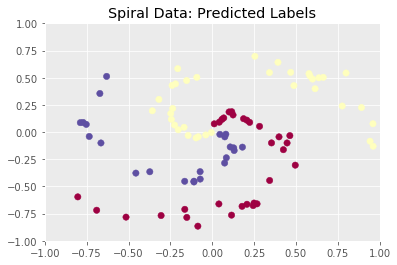

In [20]:
# Visualise the results of the linear model
label = np.argmax(predict_nn,axis=1)
fig = plot_data(x_test, label)
plt.title('Spiral Data: Predicted Labels')
plt.show()

### Conclusion: 

You can see from the plot above that by adding a hidden layer, introducing nonlinearities, the model performance is dramatically improved. 

If you would like to get a much better intuition for what a neural network is doing, then we highly recommend students refer to the [TensorFlow Playground](https://playground.tensorflow.org).

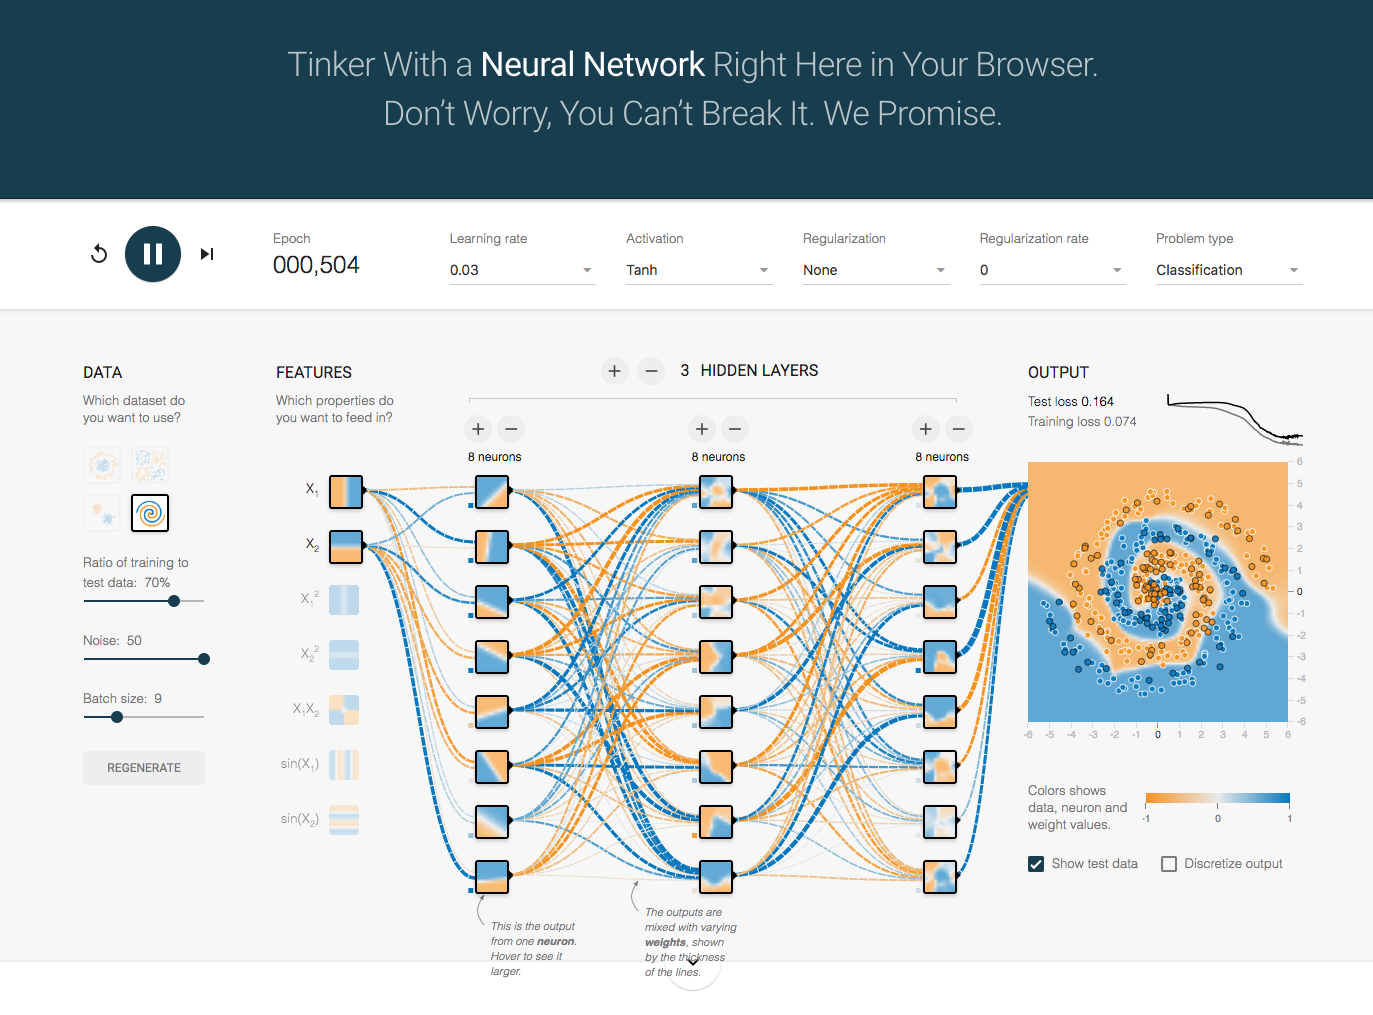

In [21]:
Image("./images/tfplay.png")

---
# Going deeper with the MNIST-dataset

We'll now switch to the MNIST dataset in order to illustrate the improvements caused by adding more layers.

**Note:** that the MNIST data set is conveniently already divided into a training set, a validation set, and a test set. The training set is used for training, and the validation set for determining the values of the hyper parameters, while the test set is used only at the end of your experimentation, to show the performance of your method.

In [22]:
# Functions
def show_weights(k=0):
    """
    Show the weights for the 10 digits.
    """
    plt.imshow(images[k], cmap='viridis') 
    plt.title('The weigths associated with digit ' + str(k))
    plt.show()

### Import the data

The MNIST data is available in TensorFlow and provides a useful helper function for feeding it in mini-batches.

In [33]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [24]:
# Inspect the images 
images = mnist.train.images.reshape((-1, 28, 28))
w = interact(show_weights, k =(0, 100))

# Note that the images have been flattened and that a one-hot encoding
# is used for the labels
print('X shape:', mnist.train.images.shape)
print('Y shape:', mnist.train.labels.shape)

interactive(children=(IntSlider(value=0, description='k'), Output()), _dom_classes=('widget-interact',))

X shape: (55000, 784)
Y shape: (55000, 10)


## Build a basic linear classifier

In [25]:
# Construction
# ============
tf.reset_default_graph()

# Specify the hyperparameters
# The MNIST images
height = 28
width = 28
channels = 1
n_inputs = height * width  # Size of MNIST images

# Output layer
n_outputs = 10  # 10 different digits for classification

with tf.name_scope("Inputs"):    
    X = tf.placeholder(tf.float32, shape=(None,n_inputs), name="X")
    y = tf.placeholder(tf.float32, shape=(None,n_outputs), name="y")

with tf.name_scope("output"):
    logits = tf.layers.dense(X, n_outputs, name="output")
    Y_prob = tf.nn.softmax(logits, name="Y_prob")

with tf.name_scope("train"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y, name="xentropy")
    loss = tf.reduce_mean(xentropy, name='loss')
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.equal(tf.argmax(logits,axis=1), tf.argmax(y,axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init"):
    init_op = tf.global_variables_initializer()

### Execution phase

One feature that should be new is the use of mini-batch training. The MNIST data has a convenient feature that allows you to extract mini-batches from the data. Unfortunately, there doesn’t seem to be a general function available that allows you to extract mini-batches from arbitrary data. Don’t worry too much about that. It is not too difficult to write your own function if you need it (or visit [Stack Overflow](https://stackoverflow.com/questions/40994583/how-to-implement-tensorflows-next-batch-for-own-data/46784876))

In [26]:
n_epochs = 10
batch_size = 50

# Execution
# =========
with tf.Session() as sess:
    # Run the 'init' op.
    sess.run(init_op)
    
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        acc_train = accuracy.eval(feed_dict={X: mnist.train.images, y: mnist.train.labels}
        acc_test  = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, ",  Test accuracy:", acc_test)   
    
    labels = sess.run(Y_prob, feed_dict={X: mnist.test.images, y: mnist.test.labels})

0 Train accuracy: 0.9060909 ,  Val accuracy: 0.9148
1 Train accuracy: 0.9159273 ,  Val accuracy: 0.919
2 Train accuracy: 0.92218184 ,  Val accuracy: 0.9246
3 Train accuracy: 0.92185456 ,  Val accuracy: 0.925
4 Train accuracy: 0.9259091 ,  Val accuracy: 0.9278
5 Train accuracy: 0.9272 ,  Val accuracy: 0.9266
6 Train accuracy: 0.92898184 ,  Val accuracy: 0.927
7 Train accuracy: 0.92881817 ,  Val accuracy: 0.9292
8 Train accuracy: 0.931 ,  Val accuracy: 0.9296
9 Train accuracy: 0.93045455 ,  Val accuracy: 0.929


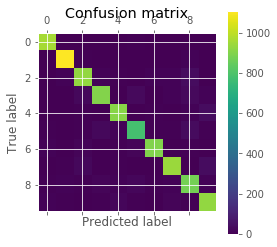

In [27]:
# Get the true and predicted labels in the correct format
t_true = np.argmax(mnist.test.labels, axis=1)
t_predict = np.argmax(labels, axis=1)

# Plot the confusion matrix.
cm = confusion_matrix(t_true, t_predict)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**Conclusion:** In this case, one cannot tell much from the graphics. Let us therefore look at the actual numbers of the confusion matrix.

In [28]:
# Print the values of the confusion matrix
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[ 961    0    2    1    0    6    4    3    2    1]
 [   0 1111    5    0    0    1    3    2   13    0]
 [   4    9  932   13    7    4   10   10   39    4]
 [   3    0   23  905    0   29    2   11   27   10]
 [   1    1    8    2  914    0    5    4    9   38]
 [   8    3    6   26    9  784    8    7   33    8]
 [  10    3   14    1    8   15  899    2    6    0]
 [   1    7   24    4    6    1    0  946    2   37]
 [   5    9    7   15    9   20    6   11  879   13]
 [  10    7    1    7   21    5    0   17    8  933]]


---
## Add a nonlinear layer
Next, lets add a nonlinear layer and see how the model performs. 

* Add a hidden layer with ReLU ativation.
* Use n_hidden_1 = 64, hidden neurons.
* Display the confusion matrix as a graph and also print the actual numbers.
* You should see a marked improvement over the linear system.

In [29]:
# Construction
# =============
tf.reset_default_graph()

# Specify the hyperparameters
# The MNIST images
height = 28
width = 28
channels = 1
n_inputs = height * width  # Size of MNIST images

n_hidden_1 = 64  # The hidden, nonlinear layer
n_outputs = 10  # Output layer

with tf.name_scope("Inputs"):    
    X = tf.placeholder(tf.float32, shape=(None,n_inputs), name="X")
    y = tf.placeholder(tf.float32, shape=(None,n_outputs), name="y")
    
with tf.name_scope("Fc"):
    fc1 = tf.layers.dense(X, n_hidden_1, activation = tf.nn.relu, name="fc")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_prob = tf.nn.softmax(logits, name="Y_prob")

with tf.name_scope("train"):
    xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y, name="xentropy")
    loss = tf.reduce_mean(xentropy, name='loss')
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.equal(tf.argmax(logits,axis=1), tf.argmax(y,axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init"):
    init_op = tf.global_variables_initializer()  

In [30]:
n_epochs = 8
batch_size = 50

# Execution
# ==========
with tf.Session() as sess:
    # Run the 'init' op.
    sess.run(init_op)
    
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)            
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        acc_train = accuracy.eval(feed_dict={X: mnist.train.images, y: mnist.train.labels})
        acc_test  = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print(epoch, "Train accuracy:", acc_train, ",  Test accuracy:", acc_test)   
    
    # Get the predictions on the test set
    labels = sess.run(Y_prob, feed_dict={X: mnist.test.images, y: mnist.test.labels})

0 Train accuracy: 0.9440182 ,  Val accuracy: 0.9466
1 Train accuracy: 0.9610909 ,  Val accuracy: 0.958
2 Train accuracy: 0.9712545 ,  Val accuracy: 0.9658
3 Train accuracy: 0.97810906 ,  Val accuracy: 0.9694
4 Train accuracy: 0.98023635 ,  Val accuracy: 0.9694
5 Train accuracy: 0.98309094 ,  Val accuracy: 0.9722
6 Train accuracy: 0.98745453 ,  Val accuracy: 0.9744
7 Train accuracy: 0.9895818 ,  Val accuracy: 0.9756


**Conclusion:** Depending on the duration of your training, you should get an accuracy on the test set exceeding 0.97. This is a significant improvement on the linear system which had only around 92% accuracy.

Below we display the confusion matrix and print the actual numbers.

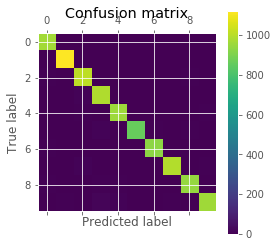

In [31]:
# Get the true and predicted labels in the correct format
t_true = np.argmax(mnist.test.labels, axis=1)
t_predict = np.argmax(labels, axis=1)

# Plot the confusion matrix.
cm = confusion_matrix(t_true, t_predict)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
# Print the values of the confusion matrix
print('Confusion Matrix:')
print(cm)

Confusion Matrix:
[[ 968    0    2    1    1    0    3    3    1    1]
 [   0 1124    4    0    0    1    2    0    4    0]
 [   6    0 1010    3    2    0    2    4    5    0]
 [   1    0   10  989    1    2    0    4    2    1]
 [   2    0    6    0  960    0    3    2    1    8]
 [   2    0    0   11    0  864    5    1    7    2]
 [   6    3    3    1    4    4  935    1    1    0]
 [   1    3   13    4    3    0    0  995    1    8]
 [   6    0    4    6    5    2    2    3  944    2]
 [   3    5    1   14   10    1    0    8    4  963]]
